In [1]:
import cv2
import os
import numpy as np
from random import shuffle
import imutils
import matplotlib.pyplot as plt
from skimage import data, color, exposure
from sklearn.linear_model import LogisticRegression

import cPickle as pickle
import data_generator as dg
import multiscale_detect as md
import kmeansutil as ku
import nonmaxsupp as nms
import utils as ut
%matplotlib inline  

Get data array from generate_data module. Randomize the array. Pick sample_size amount from each

Data is stored in a pickled zipped list of features and labels

In [8]:
#get positive images, determine best ratios (rows over columns), assign to images
def remove_red(img):
    img[:,:,2] = 0
    return img

pimages = dg.getImagesFromJSON(open("labels.json").read())
pimages = [remove_red(x) for x in pimages]
print len(pimages)

270


Separate positive images into aspect ratios, get negative images and crop to aspect ratios

In [10]:
#get negative images, use ratios found for positive images to match
nimages = dg.getRandomMultiple("sun_images", 200, 0)
partialsignimgs = dg.getRandomMultiple("partial", 200, 0)
nimages = nimages+partialsignimgs
nimages = [x[1] for x in nimages]

print len(nimages)


400


Generate features from HOGs and images for each label and aspect ratio

In [14]:
def getFeaturesWithLabel(imageData, hog, dims, label):
    data = []
    for img in imageData: 
        img = cv2.resize(img, dims)

        #for images with transparency layer, reduce to 3 layers
        feat = hog.compute(img[:,:,:3])
        
        data.append((feat, label))
    return data


In [15]:
minDim = 80
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = -1
histogramNormType = 0
L2HysThreshold = 2.1e-1
gammaCorrection = 0
nlevels = 64

dims = (80,80)

hog = cv2.HOGDescriptor(dims,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

In [16]:
pdata = getFeaturesWithLabel(pimages, hog, dims, 1)
ndata = getFeaturesWithLabel(nimages, hog, dims, 0)

data = pdata + ndata
shuffle(data)

feat, labels = map(list, zip(*data))
feat = [x.flatten() for x in feat]

sample_size = len(feat)
train_size = int(round(0.8*sample_size))


In [17]:
train_feat = np.array(feat[:train_size], np.float32)
test_feat = np.array(feat[train_size: sample_size], np.float32)
train_label = np.array(labels[:train_size])
test_label = np.array(labels[train_size:sample_size])


Train classifier

In [18]:
lsvm = LogisticRegression()
lsvm.fit(train_feat, train_label)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Compute and display training accuracy

In [19]:
print lsvm.score(train_feat, train_label)

1.0


Compute and display test set accuracy, true and false positives, true and false negatives, list of files that were misclassified

In [20]:
#compute test accuracy
result = lsvm.predict(test_feat)
print "test accuracy ", lsvm.score(test_feat, test_label)
ut.printConfusionMatrix(result, test_label)




test accuracy  0.932835820896
true pos: 50 true neg: 75 false pos: 5 false neg: 4 



In [21]:
def getHardNegativeFeatures(lsvm, hog, imgDir, step=1, scale=1.1):
    #get dataset of negative images to scan through
    negFiles = dg.getAllFiles(imgDir)
    negImgs = []
    falsePos_feat = []
    signs = 0
    nosigns = 0

    for f in negFiles:
        negImgs.append([f, cv2.imread(imgDir + "/" + f)])
    
    if len(negImgs) == 0:
        raise "No images found"

    #multiscale detect
    counter = 1
    for row in negImgs:
        scales = md.pyramid(row[1], scale, minSize=(30, 30))
        winw = hog.winSize[1]
        winh = hog.winSize[0]

        for img in scales:
            results = []

            for (x, y, window) in md.sliding_window(img, step, (winw, winh)):        
                if window.shape[0] != winh or window.shape[1] != winw:
                    continue
                window = cv2.resize(window, (winh, winw))
                feat = hog.compute(window)
                result = lsvm.predict(feat.reshape(1,-1))
                if result == 1:  
                    falsePos_feat.append(feat)
                    signs +=1
                else:
                    nosigns+=1
        counter +=1

    falsePosFeat = [x.flatten() for x in falsePos_feat] 
    return falsePosFeat

In [22]:
hardNeg = getHardNegativeFeatures(lsvm, hog, "hwy_empty", step=60, scale=1.5)
print "number of false positives for classifiers", len(hardNeg)

number of false positives for classifiers 1046


In [23]:
#retrain classifiers
hNLabels = [0] * len(hardNeg)

if hardNeg:
    train_features_wfp = np.r_[train_feat, np.array(hardNeg)]
    train_labels_wfp = np.r_[train_label, np.array(hNLabels)]
    lsvm.fit(train_features_wfp, train_labels_wfp)
    print "retraining accuracy", lsvm.score(train_features_wfp, train_labels_wfp)
    result = lsvm.predict(test_feat)
    print "retrain test accuracy", lsvm.score(test_feat, test_label)
    ut.printConfusionMatrix(result, test_label)


retraining accuracy 0.998103666245
retrain test accuracy 0.940298507463
true pos: 47 true neg: 79 false pos: 1 false neg: 7 



Find and display signs in a test image

In [24]:
#helper function for resizing images
def resize(img, scale):
    return cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)))

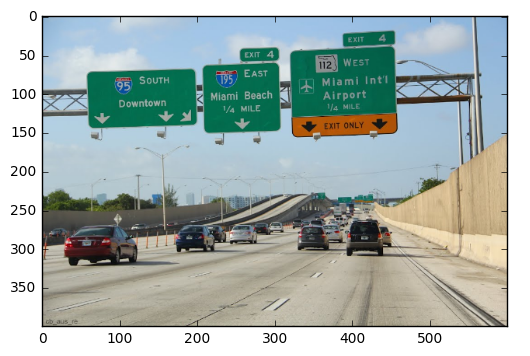

In [97]:
im = cv2.imread("multiscale_test/191.jpg")
if im.shape[0] > 400:
    scale = 400.0/im.shape[0]
else: scale = 1
im = resize(im, scale)

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

Preprocess image, get regions of interest bounding boxes using contours, color filtering, thresholding

In [98]:
def preprocess(image, (lower, upper)):

    #boundary in bgr color scheme for opencv

    lower = np.array(lower, dtype="uint8")
    upper = np.array(upper, dtype="uint8")
    
    #apply smoothing
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(image,-1,kernel)

    # find the colors within the specified boundaries and apply
    # the mask
    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask = mask)
    
    return output, mask

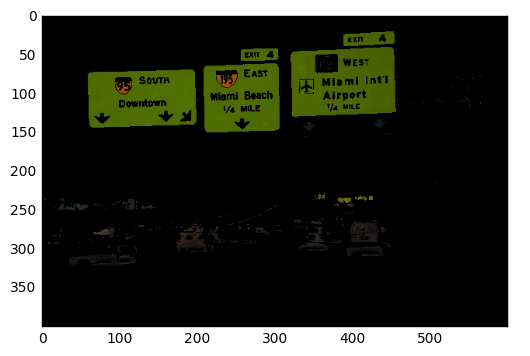

In [99]:
pimage, mask = preprocess(im,  ([0,0,0], [255, 255, 40]))
plt.imshow(pimage)
plt.show()

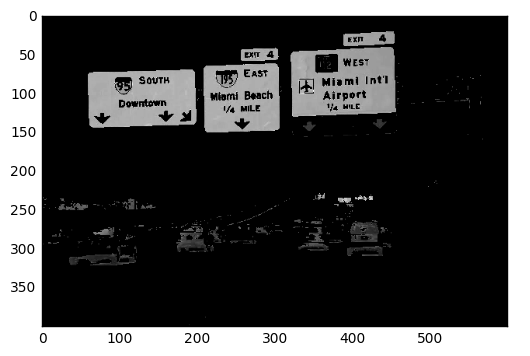

In [100]:
imgray = cv2.cvtColor(pimage,cv2.COLOR_BGR2GRAY)
plt.imshow(imgray, cmap='gray')
plt.show()

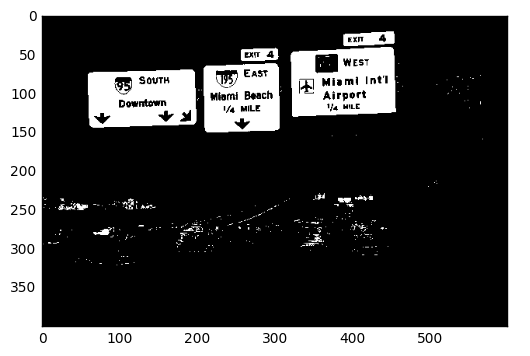

In [101]:
flag, binaryImage = cv2.threshold(imgray, 85, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU )
plt.imshow(binaryImage, cmap='gray')
plt.show()

In [102]:
im2, contours, hierarchy = cv2.findContours(binaryImage,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

442
6


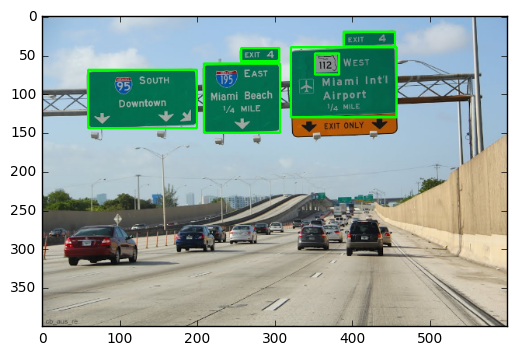

In [103]:
copy = im.copy()
rgb = rgb = cv2.cvtColor(copy, cv2.COLOR_BGR2RGB)

boxes = [cv2.boundingRect(c) for c in contours]
print len(boxes)
boxes2 = [b for b in boxes if b[2]*b[3] > 600]
print len(boxes2)

for x, y, w, h in boxes2:
    cv2.rectangle(rgb, (x,y),(x+w, y+h), (0, 255, 0), 2)
plt.imshow(rgb)
plt.show()

Apply HOG to bounding boxes for result

In [104]:
def transform_scale(factor, boxes):
    return [[int(x[0]*factor), int(x[1]*factor), int(x[2]*factor), int(x[3]*factor)] for x in boxes]

In [105]:
real_signs = []

for x, y, w, h in boxes2:
    #get slice at box:
    window = im[y:y+h, x:x+w, :3]
    window = cv2.resize(window, dims)
    feat = hog.compute(window)
    prob = lsvm.predict_proba(feat.reshape(1,-1))[0]          
#     plt.imshow(cv2.cvtColor(window, cv2.COLOR_BGR2RGB))
#     plt.show()
#     print prob[1]
    if prob[1] > .1:  
        real_signs.append((x,y,w,h))
    
print len(real_signs)


6


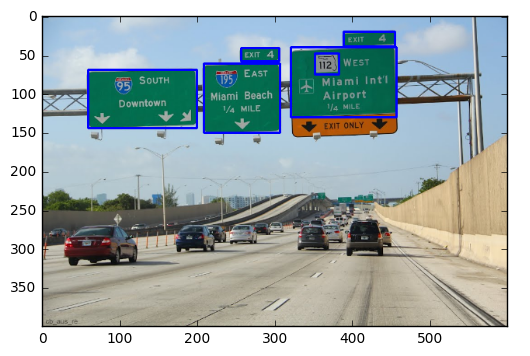

In [106]:
clone = im.copy()

colors = [(0,255,0),(0,0,0),(255,0,255),(255,0,0),(255,165,0),(255,255,255), (1, 1, 1)]
for x, y, w, h in real_signs:
     

    cv2.rectangle(clone, (x, y), (x+w, y+h), colors[3], 2)

plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
plt.show()